<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

# **Artificial Intelligence - MSc**
## ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-10-02' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20156952" #@param {type:"string"}
Student_full_name = "Dáire Campbell" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Final' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

### Task: 

You have to create a  *piecewise regression* model following the guidelines from the notebook provided to predict the house price using the provided dataset in the GitHub repository.

* Get the dataset: train, test, and true price.
* Analyse the dataset and decide what features to use.
* Clean the dataset: remove nan's and possible outliers.
* You could remove registers with 0 bathrooms and 0 bedrooms.
* Your goal is to use a piecewise regression to solve this problem.
* Follow the guidelines from the example provided.
* Apply a full model first as a baseline.
* You could select longitude and latitude to create clusters.
* Use the number of clusters you model returns.
* Apply a model to each cluster.
* Analyse the results and give a comparison from both approaches
* You could split the training to get a validation dataset.
* Take notes from all the experiment results and bring your insights in your summary.



This task is to compare linear regression and piecewise linear regression.  
The advantage of this is the data may have underlying linear relationships, but a single linear model wont be able to distinguish.  

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
import pprint
from sklearn.preprocessing import StandardScaler

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# use seaborn plotting defaults
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [12, 8] 

# XGBoost for feature selection
from xgboost import XGBClassifier
from xgboost import plot_importance

# Improve the Jupyter Notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Improve pandas dataframe results
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


In [7]:
# Define the seed so that results can be reproduced
seed = 20179
rand_state = 20179

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

In [8]:
# Setting a seed:
np.random.seed(seed)

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Get the dataset: train, test, and true price.

In [ ]:
# The code runs quicker locally, but
# I have a Colab version for distribution.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Masters_in_AI/et5003/etivity2/'
    print("Running in Colab.")
except Exception as e:
    print("Running locally.")
    Path = "./"

In [9]:
# Load data
house_train = pd.read_csv(Path+"house_train.csv")
house_train = house_train[house_train["price"].notna()]
house_train = house_train.rename(columns = {"price": "Expected"})

house_test = pd.read_csv(Path+"house_test.csv")
true_price = pd.read_csv(Path+"true_price.csv")
# Add house value to the dataset

house_test = house_test.merge(
    true_price,
    left_on = "ad_id",
    right_on = "Id",
    how = "inner")

<AxesSubplot:xlabel='Expected', ylabel='Density'>

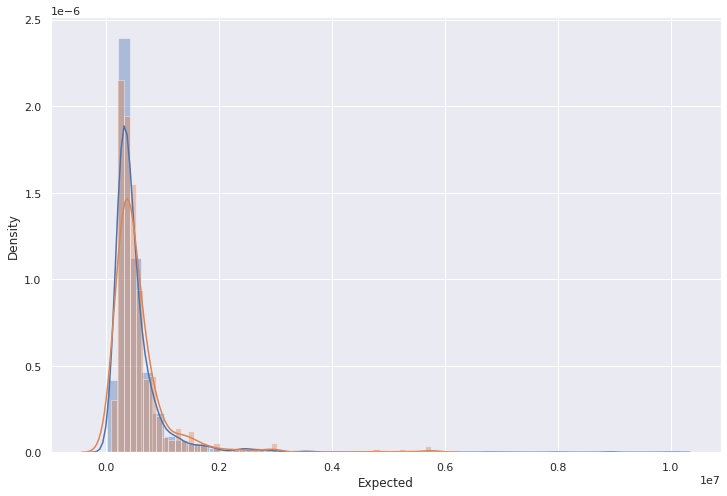

In [10]:
# Confirm the price distributions are the similiar
# between the reaining and test datasets.
sns.distplot(house_train["Expected"])
sns.distplot(house_test["Expected"])

## Clean the dataset: remove nan's and possible outliers.

In [11]:
# Map from area to Dublin postcode
# This will reduce number of features in areas
area_to_postcode = {
    'Temple Bar':'Dublin 1', 'IFSC':'Dublin 1', 
    'Grand Canal Dock':'Dublin 2',
    'Clontarf':'Dublin 3', 'East Wall':'Dublin 3', 'North Strand':'Dublin 3', 'Fairview':'Dublin 3', 'Marino':'Dublin 3', 'Ballyboughal':'Dublin 3', 
    'Ballsbridge':'Dublin 4', 'Donnybrook':'Dublin 4','Sandymount':'Dublin 4','Ringsend':'Dublin 4','Irishtown':'Dublin 4','Merrion':'Dublin 4',
    'Artane':'Dublin 5','Raheny':'Dublin 5','Kilbarrack':'Dublin 5','Edenmore':'Dublin 5','Kilmore':'Dublin 5','Donnycarney':'Dublin 5',
    'Rathmines':'Dublin 6','Rathgar':'Dublin 6','Ranelagh':'Dublin 6','Milltown':'Dublin 6','Dartry':'Dublin 6',
    'Stoneybatter':'Dublin 7','Phibsborough':'Dublin 7','Navan Road (D7)':'Dublin 7','North Circular Road':'Dublin 7','Smithfield':'Dublin 7','Ashtown':'Dublin 7','Cabra':'Dublin 7',
    'Kilmainham':'Dublin 8','Inchicore':'Dublin 8','Rialto':'Dublin 8','Portobello':'Dublin 8','South Circular Road':'Dublin 8','Islandbridge':'Dublin 8','The Coombe':'Dublin 8',"Dolphin's Barn":'Dublin 8','Christchurch':'Dublin 8',
    'Drumcondra':'Dublin 9','Glasnevin':'Dublin 9','Santry':'Dublin 9','Whitehall':'Dublin 9','Beaumont':'Dublin 9','Ballymun':'Dublin 9','Poppintree':'Dublin 9',
    'Ballyfermot':'Dublin 10','Cherry Orchard':'Dublin 10',
    'Finglas':'Dublin 11',"St Margaret's":'Dublin 11',
    'Walkinstown':'Dublin 12','Crumlin':'Dublin 12','Drimnagh':'Dublin 12','Bluebell':'Dublin 12','Park West':'Dublin 12','Perrystown':'Dublin 12',
    'Malahide':'Dublin 13','Howth':'Dublin 13','Sutton':'Dublin 13','Baldoyle':'Dublin 13','Donaghmede':'Dublin 13','Bayside':'Dublin 13','Ard Na Greine':'Dublin 13','Clongriffin':'Dublin 13','Clarehall':'Dublin 13',
    'Dundrum':'Dublin 14','Churchtown':'Dublin 14','Goatstown':'Dublin 14','Clonskeagh':'Dublin 14','Windy Arbour':'Dublin 14',
    'Carpenterstown':'Dublin 15','Castleknock':'Dublin 15','Clonsilla':'Dublin 15','Blanchardstown':'Dublin 15','Clonee':'Dublin 15','Coolmine':'Dublin 15','Hartstown':'Dublin 15','Mulhuddart':'Dublin 15','The Ward':'Dublin 15','Ongar':'Dublin 15','Tyrrelstown':'Dublin 15',
    'Rathfarnham':'Dublin 16','Ballinteer':'Dublin 16','Ballinascorney':'Dublin 16','Knocklyon':'Dublin 16',
    'Darndale':'Dublin 17','Clonshaugh':'Dublin 17','Coolock':'Dublin 17','Killester':'Dublin 17',
    'Deansgrange':'Dublin 18','Sandyford':'Dublin 18','Foxrock':'Dublin 18','Stepaside':'Dublin 18','Cabinteely':'Dublin 18','Carrickmines':'Dublin 18','Leopardstown':'Dublin 18','Kilternan':'Dublin 18','Shankill':'Dublin 18',
    'Palmerstown':'Dublin 20','Chapelizod':'Dublin 20','Lucan':'Dublin 20',
    'Clondalkin':'Dublin 22','Kingswood':'Dublin 22','Newcastle':'Dublin 22',
    'Ballymount':'Dublin 24','Kiltipper':'Dublin 24','Tallaght':'Dublin 24','Balrothery':'Dublin 24','Rathcoole':'Dublin 24','Kilnamanagh':'Dublin 24','Firhouse':'Dublin 24','Greenhills':'Dublin 24','Oldbawn':'Dublin 24','Adamstown':'Dublin 24','Saggart':'Dublin 24','Citywest':'Dublin 24','Ballycullen':'Dublin 24','Brittas':'Dublin 24',
    'Terenure':'Dublin 6w',"Harold's Cross":'Dublin 6w','Kimmage':'Dublin 6w','Templeogue':'Dublin 6w',
    'Donabate':'Co. Fingal','Swords':'Co. Fingal','Portmarnock':'Co. Fingal','Kinsealy':'Co. Fingal','Balgriffin':'Co. Fingal','Garristown':'Co. Fingal','Naul':'Co. Fingal','Skerries':'Co. Fingal','Rush':'Co. Fingal','Lusk':'Co. Fingal','Balbriggan':'Co. Fingal','Loughshinny':'Co. Fingal','Ballybough':'Co. Fingal',
    'Blackrock':'Co. Dun Laoghaire-Rathdown','Dun Laoghaire':'Co. Dun Laoghaire-Rathdown','Glenageary':'Co. Dun Laoghaire-Rathdown',
    'Monkstown':'Co. Dun Laoghaire-Rathdown','Booterstown':'Co. Dun Laoghaire-Rathdown','Sandycove':'Co. Dun Laoghaire-Rathdown',
    'Rathmichael':'Co. Dun Laoghaire-Rathdown','Mount Merrion':'Co. Dun Laoghaire-Rathdown','Ballybrack':'Co. Dun Laoghaire-Rathdown','Sallynoggin':'Co. Dun Laoghaire-Rathdown',
    'Kilmacud':'Co. Dun Laoghaire-Rathdown','Dalkey':'Co. Dun Laoghaire-Rathdown','Killiney':'Co. Dun Laoghaire-Rathdown','Loughlinstown':'Co. Dun Laoghaire-Rathdown',
    }


In [12]:
# Map from Dublin postcode to a flag 
# if its southside or northside
postcode_north_south = {
    "Co. Fingal":False,
    "Co. Dun Laoghaire-Rathdown":True,
    "Dublin 4":True,
    "Dublin 18":True,
    "Dublin 15":False,
    "Dublin 6":True,
    "Dublin 6w":True,
    "Dublin 3":False,
    "Dublin 16":True,
    "Dublin 13":False,
    "Dublin 9":False,
    "Dublin 7":False,
    "Dublin 24":True,
    "Dublin 20":True,
    "Dublin 5":False,
    "Dublin 12":True,
    "Dublin 8":True,
    "Dublin 14":True,
    "Dublin 22":True,
    "Dublin 17":False,
    "Dublin 11":False,
    "Dublin 2":True,
    "Dublin 10":True,
    "Dublin 1":False
}

In [13]:
def pre_processing_features(df):
    """
    Function to preprocess features.
    This includes One-Hot Encoding and 
    encoding columns.

    Creating a function as will be applied to both 
    Training and Testing data.

    ::param df: (pandas dataframe)
    ::param data: (pandas dataframe)
        Data to use to fill empty values and to encode
        Using Training data to not bias results
    ::param ber_dict: (dict)
    ::return: (pandas dataframe)
    """
    # Creating a mapping from ber letter to number
    # ber classification is ordinal
    ber_numbers = sorted(df.ber_classification.fillna(
        df.ber_classification.mode()[0]).unique())
    ber_dict = dict(zip(ber_numbers, range(len(ber_numbers))))
    
    # Encoding
    # Fill NaN values with mode
    df["ber_classification"] = df["ber_classification"]\
        .map(ber_dict)\
        .fillna(ber_dict[df.ber_classification.mode()[0]])
    
    return df


def create_new_features(dataframe):
    """
    Functions to parse out new feaures from the dataframe.
    These are:
        - Alarm
        - Gas Fired Central Heating
        - Oil Fired Central Heating
        - Parking
        - Wheelchair Access
        - Wired for Cable Television

    ::param dataframe: (pandas DataFrame)
    ::return: (pandas DataFrame)
    """
    print(
        "Percentage Facility populated: ",
        sum(dataframe["facility"].notna())*100/len(dataframe), "%")
    
    for fac in [
        "Alarm",
        "Gas Fired Central Heating",
        "Oil Fired Central Heating",
        "Parking",
        "Wheelchair Access",
        "Wired for Cable Television"]:
        dataframe[fac.lower().replace(" ", "_")] = dataframe["facility"].str.contains(fac).fillna(False)
    
    dataframe["postcode"] = dataframe["area"].map(area_to_postcode)
    
    postcode = pd.get_dummies(dataframe["postcode"])
    dataframe[postcode.columns] = postcode
    
    dataframe["postcode_north_south"] = dataframe["postcode"].map(postcode_north_south)

    property_type = pd.get_dummies(dataframe["property_type"])
    dataframe[property_type.columns] = property_type  
    
    dataframe = pre_processing_features(dataframe)
    
    return dataframe

In [14]:
# Apply preprocessing
house_train = create_new_features(house_train)
house_test = create_new_features(house_test)

Percentage Facility populated:  32.84923928077455 %
Percentage Facility populated:  37.8 %


In [15]:
# Add columns to test data from training data
# These could be missing from One Hot Encoding etc

for column in list(
    set(house_train.columns) - set(house_test.columns)):
    print(column)
    house_test[column] = 0

In [16]:
# Describe the Features
house_train.describe(include='all')

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,Expected,property_category,property_type,surface,alarm,gas_fired_central_heating,oil_fired_central_heating,parking,wheelchair_access,wired_for_cable_television,postcode,Co. Dun Laoghaire-Rathdown,Co. Fingal,Dublin 1,Dublin 10,Dublin 11,Dublin 12,Dublin 13,Dublin 14,Dublin 15,Dublin 16,Dublin 17,Dublin 18,Dublin 2,Dublin 20,Dublin 22,Dublin 24,Dublin 3,Dublin 4,Dublin 5,Dublin 6,Dublin 6w,Dublin 7,Dublin 8,Dublin 9,postcode_north_south,apartment,bungalow,detached,duplex,end-of-terrace,semi-detached,site,studio,terraced,townhouse
count,2.892000e+03,2892,2892.000000,2892.000000,2892.000000,2892,2892,2892,950,2892,2892.000000,2892.000000,7.000000,2.892000e+03,2892,2892,2402.000000,2892,2892,2892,2892,2892,2892,2696,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2696,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000
unique,NaN,152,NaN,NaN,NaN,1,2889,1,34,1856,NaN,NaN,NaN,NaN,2,10,NaN,2,2,2,2,2,2,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Finglas,NaN,NaN,NaN,Dublin,Sycamore Grove is a small development of 14 ho...,prod,"Parking,Gas Fired Central Heating",None,NaN,NaN,NaN,NaN,sale,apartment,NaN,False,False,False,False,False,False,Co. Fingal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,92,NaN,NaN,NaN,2892,2,2892,184,1031,NaN,NaN,NaN,NaN,2885,756,NaN,2569,2275,2819,2053,2833,2490,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.230511e+07,NaN,1.991355,2.975450,8.909059,NaN,NaN,NaN,NaN,NaN,53.355579,-6.257373,1.142857,5.323536e+05,NaN,NaN,315.199039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087483,0.103734,0.003458,0.004495,0.031812,0.029737,0.060512,0.029046,0.073997,0.044260,0.010028,0.053596,0.003458,0.033195,0.024550,0.061895,0.033195,0.043914,0.023513,0.027663,0.026971,0.032158,0.021438,0.068119,NaN,0.261411,0.027663,0.133126,0.020747,0.081259,0.258990,0.016598,0.001037,0.189834,0.009336
std,2.173032e+05,NaN,1.266439,1.452494,2.793423,NaN,NaN,NaN,NaN,NaN,0.086445,0.142864,0.377964,5.678148e+05,NaN,NaN,4414.586954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282590,0.304968,0.058712,0.066907,0.175529,0.169891,0.238474,0.167964,0.261812,0.205708,0.099652,0.225258,0.058712,0.179176,0.154777,0.241006,0.179176,0.204940,0.151553,0.164032,0.162027,0.176449,0.144866,0.251993,NaN,0.439479,0.164032,0.339769,0.142560,0.273279,0.438156,0.127780,0.032197,0.392238,0.096188
min,9.124101e+06,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,51.458439,-6.521183,1.000000,1.999500e+04,NaN,NaN,3.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.227543e+07,NaN,1.000000,2.000000,7.000000,NaN,NaN,NaN,NaN,NaN,53.299255,-6.313874,1.000000,2.800000e+05,NaN,NaN,73.725000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.237885e+07,NaN,2.000000,3.000000,9.000

Columns : property_type
apartment         756
semi-detached     749
terraced          549
detached          385
end-of-terrace    235
bungalow           80
duplex             60
site               48
townhouse          27
studio              3
Name: property_type, dtype: int64

Columns : ber_classification
9.0     891
10.0    272
8.0     264
7.0     242
6.0     211
11.0    182
12.0    168
14.0    164
13.0    163
5.0     130
4.0      73
2.0      66
15.0     25
1.0      24
3.0      16
0.0       1
Name: ber_classification, dtype: int64

Columns : postcode
Co. Fingal                    300
Co. Dun Laoghaire-Rathdown    253
Dublin 15                     214
Dublin 9                      197
Dublin 24                     179
Dublin 13                     175
Dublin 18                     155
Dublin 16                     128
Dublin 4                      127
Dublin 3                       96
Dublin 20                      96
Dublin 7                       93
Dublin 11                      92

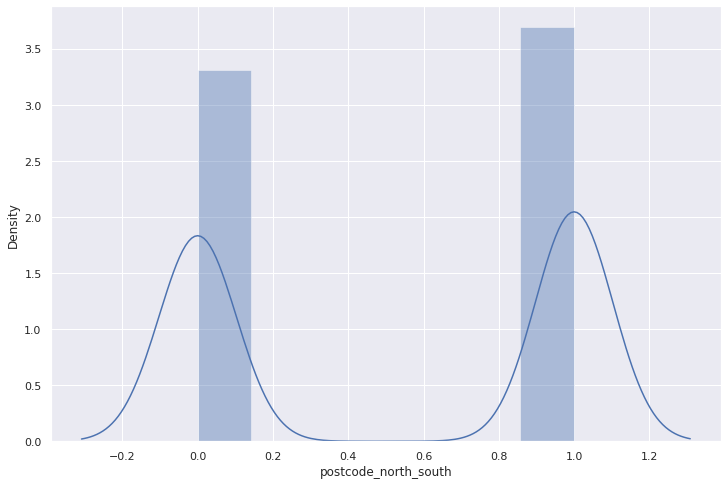


Columns : beds


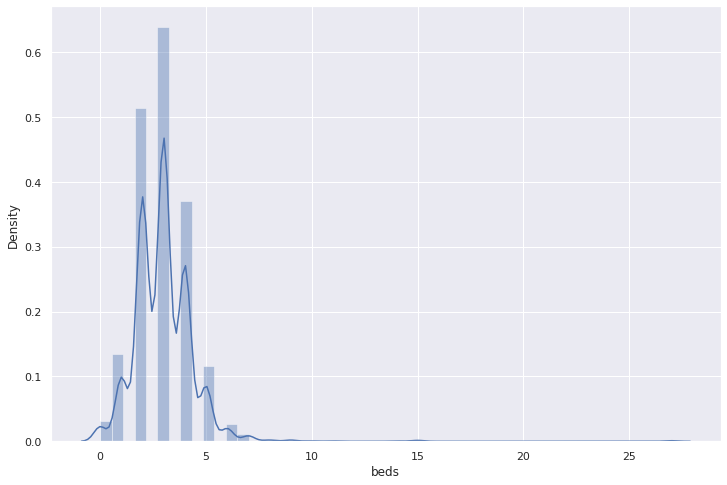


Columns : bathrooms


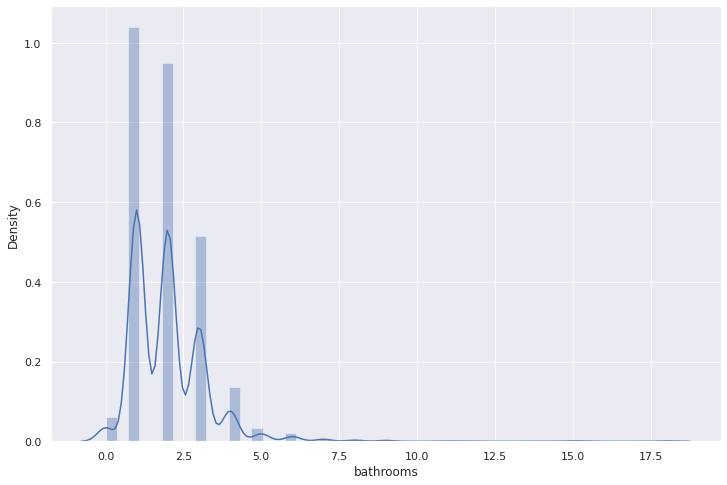


Columns : surface


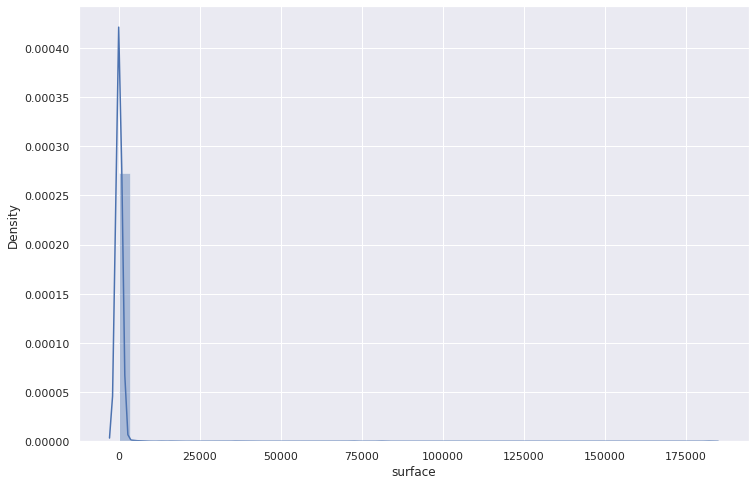


Columns : latitude


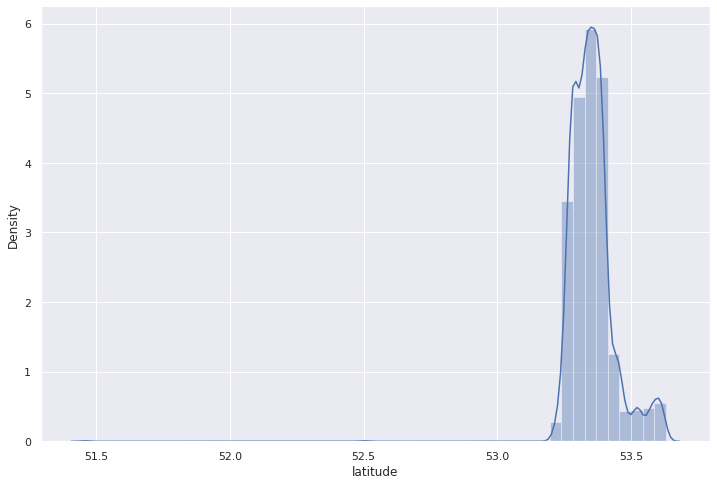


Columns : longitude


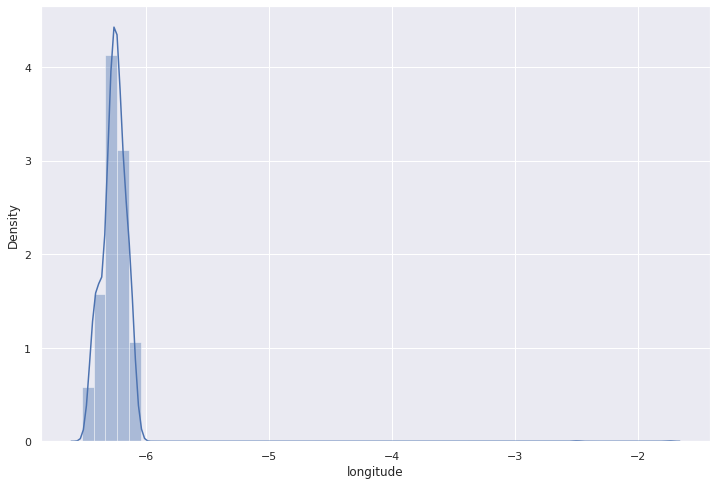


Columns : cost


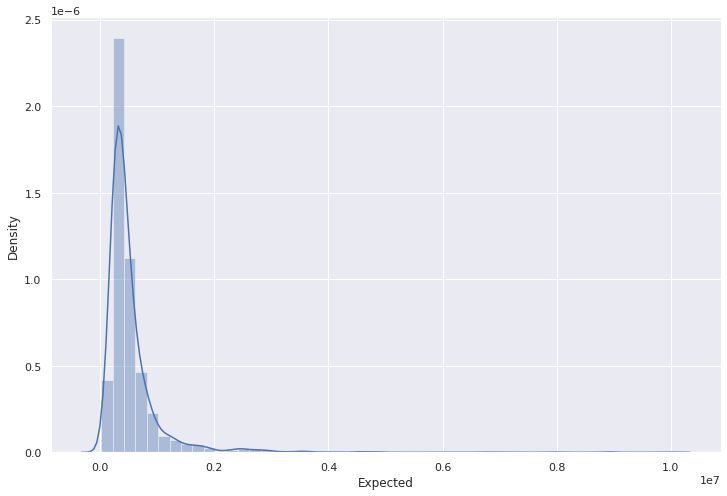

In [17]:
# Visualise distribution
for column in [
    "property_type","ber_classification","postcode"]:
    print("Columns :", column)
    pprint.pprint(house_train[column].value_counts())
    print("")
    
for column in [
    "postcode_north_south", "beds", "bathrooms", "surface", "latitude", "longitude"]:
    print("Columns :", column)
    sns.distplot(house_train[column])
    plt.show()
    print("")

print("Columns :", "cost")
sns.distplot(house_train["Expected"])
plt.show()

#### Note:
The surface appears to be skewed.  
I will remove all surface values greater than 1000.

I will remove any values with beds, bathrooms = 0

I will filter longitude, keeping values less than -6.
I will filter latitude, keeping values greater than 53.

In [18]:
print(f"Origional length of training data: {len(house_train)}")

house_train = house_train[house_train["surface"] < 1000]
print(f"Length of house_train is now {len(house_train)}, after removing surface outliers.")

house_train = house_train[house_train["beds"] > 0]
print(f"Length of house_train is now {len(house_train)}, after removing beds outliers.")

house_train = house_train[house_train["bathrooms"] >0]
print(f"Length of house_train is now {len(house_train)}, after removing bathroom outliers.")

house_train = house_train[house_train["longitude"] < -6]
print(f"Length of house_train is now {len(house_train)}, after removing longitude outliers.")

house_train = house_train[house_train["latitude"] > 53]
print(f"Length of house_train is now {len(house_train)}, after removing latitude outliers.")


Origional length of training data: 2892
Length of house_train is now 2377, after removing surface outliers.
Length of house_train is now 2356, after removing beds outliers.
Length of house_train is now 2343, after removing bathroom outliers.
Length of house_train is now 2342, after removing longitude outliers.
Length of house_train is now 2342, after removing latitude outliers.


In [19]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = \
    house_train.drop("Expected", axis = 1),\
    house_test.drop("Expected", axis = 1),\
    house_train["Expected"],\
    house_test["Expected"]

X_train["cost"] = y_train

len(X_train), len(X_test), len(y_train), len(y_test)

(2342, 500, 2342, 500)

## Analyse the dataset and decide what features to use.
We perform some feature selection to select the best features to use on regression.

In [20]:
# This is our complete list of columns
feature_columns = [
    'bathrooms',
    'beds',
    'ber_classification',
    'latitude',
    'longitude',
    'surface',
    'alarm', 'gas_fired_central_heating', 'oil_fired_central_heating', 'parking', 'wheelchair_access', 'wired_for_cable_television',
    'Co. Dun Laoghaire-Rathdown',
    'Co. Fingal', 'Dublin 1', 'Dublin 10', 'Dublin 11', 'Dublin 12',
    'Dublin 13', 'Dublin 14', 'Dublin 15', 'Dublin 16', 'Dublin 17',
    'Dublin 18', 'Dublin 2', 'Dublin 20', 'Dublin 22', 'Dublin 24',
    'Dublin 3', 'Dublin 4', 'Dublin 5', 'Dublin 6', 'Dublin 6w', 'Dublin 7',
    'Dublin 8', 'Dublin 9',
    'postcode_north_south',
    'apartment', 'bungalow',
    'detached', 'duplex', 'end-of-terrace', 'semi-detached', 'site',
    'studio', 'terraced', 'townhouse']

[22:15:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.0187698  0.02398863 0.01824963 0.01877474 0.01932599 0.02831503
 0.01970797 0.01908562 0.02011102 0.01836642 0.02285843 0.01888219
 0.02566174 0.02143701 0.         0.03280779 0.02425022 0.01679527
 0.01729884 0.02358554 0.02666869 0.0205232  0.02453621 0.0242182
 0.0143421  0.0130707  0.02290522 0.02692144 0.02552676 0.02539854
 0.02414068 0.03373913 0.02246274 0.02811137 0.02357523 0.02351958
 0.01901752 0.02692986 0.02211781 0.02438849 0.02952439 0.02502627
 0.01874216 0.         0.         0.01596862 0.03035319]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

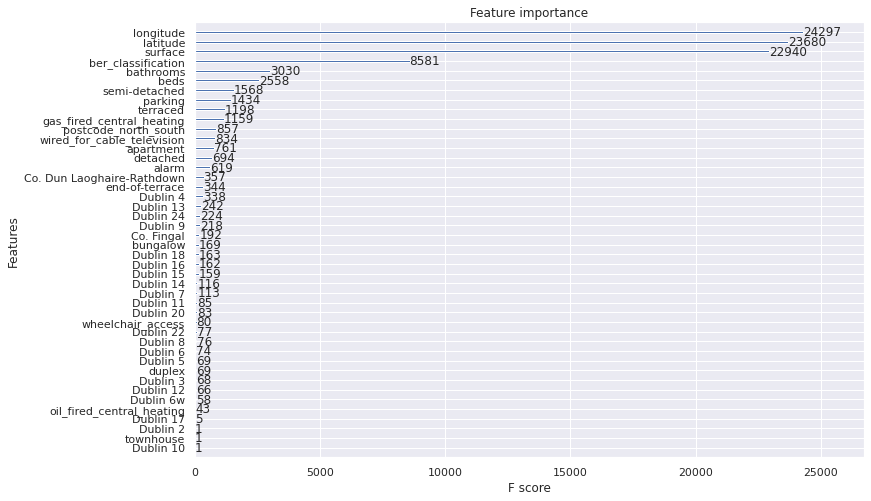

In [21]:
# We will use XGBoost to perform feature select.
# Will use the XGBoost F score, to selelct the best features.

def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}


# fit model no training data
xgb = XGBClassifier()
xgb.fit(X_train[feature_columns].astype(float), X_train["cost"])
# feature importance
print(xgb.feature_importances_)
# plot
plot_importance(xgb)

In [22]:
# Convert the features to a list
# Keeping anything above a certian threshold

feature_weights = xgb.get_booster().get_fscore()

rel_features = [k for k, v in sorted(feature_weights.items(), key=lambda item: item[1], reverse=True) if v > 400]
print("Columns for model :\n", ",\n".join(rel_features))

Columns for model :
 longitude,
latitude,
surface,
ber_classification,
bathrooms,
beds,
semi-detached,
parking,
terraced,
gas_fired_central_heating,
postcode_north_south,
wired_for_cable_television,
apartment,
detached,
alarm


In [23]:
## create train data frame
# use meaningful names
dftrain = X_train[rel_features + ["cost"]]

In [24]:
## create test data frame
# no cost included
dftest = X_test[rel_features]

In [25]:
## create expected cost data frame
# the cost is in another file
dfcost = DataFrame(dict(cost=y_test))
# show first data frame rows 
dfcost.head()

,cost
0,875000.0
1,355000.0
2,440000.0
3,425000.0
4,265000.0


### Train dataset

In [26]:
syntPath = "./house/"
filename1 = "Train.csv"
filename2 = "Test.csv"
filename3 = "Cost.csv"

# training dataset: 
training_file = syntPath+filename1
# test dataset: 
testing_file = syntPath+filename2
# cost dataset: 
cost_file = syntPath+filename3

In [27]:
# show first data frame rows 
dftrain.head()

,longitude,latitude,surface,ber_classification,bathrooms,beds,semi-detached,parking,terraced,gas_fired_central_heating,postcode_north_south,wired_for_cable_television,apartment,detached,alarm,cost
15,-6.445730,53.400454,321.0,2.0,3.0,5.0,0,False,0,False,False,False,0,1,False,935000.0
26,-6.385214,53.316410,144.0,2.0,4.0,4.0,1,False,0,False,True,False,0,0,False,485000.0
27,-6.446634,53.401414,321.0,2.0,3.0,5.0,0,False,0,False,False,False,0,1,False,935000.0
35,-6.056749,53.375377,312.0,1.0,5.0,5.0,0,False,0,False,False,False,0,1,False,1475000.0
38,-6.338466,53.372130,83.0,2.0,2.0,2.0,0,False,0,False,False,False,1,0,False,410000.0


In [28]:
# Generate descriptive statistics
dftrain.describe()

,longitude,latitude,surface,ber_classification,bathrooms,beds,semi-detached,terraced,apartment,detached,cost
count,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2.342000e+03
mean,-6.256335,53.350808,120.011430,8.883860,2.040991,3.017933,0.268574,0.184458,0.267720,0.143467,5.614961e+05
std,0.091887,0.073850,84.457911,2.906812,1.142190,1.233736,0.443312,0.387940,0.442865,0.350623,5.991795e+05
min,-6.521183,53.214227,3.400000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.999500e+04
25%,-6.308758,53.294942,73.000000,7.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.950000e+05
50%,-6.247867,53.341235,97.500000,9.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.950000e+05
75%,-6.189664,53.381966,136.000000,11.000000,3.000000,4.000000,1.000000,0.000000,1.000000,0.000000,5.950000e+05
max,-6.054719,53.630588,985.000000,15.000000,15.000000,15.000000,1.000000,1.000000,1.000000,1.000000,9.995000e+06


### Test dataset

In [29]:
# show first data frame rows 
dftest.head()

,longitude,latitude,surface,ber_classification,bathrooms,beds,semi-detached,parking,terraced,gas_fired_central_heating,postcode_north_south,wired_for_cable_television,apartment,detached,alarm
0,-6.101148,53.566881,142.0,13.0,2.0,4.0,0,True,0,False,False,False,0,0,True
1,-6.452909,53.362992,114.0,5.0,2.0,3.0,0,False,1,False,True,False,0,0,False
2,-6.262964,53.454198,172.0,4.0,3.0,4.0,1,False,0,False,False,False,0,0,False
3,-6.458647,53.354402,132.4,1.0,4.0,3.0,1,False,0,False,True,False,0,0,False
4,-6.393587,53.336530,88.0,11.0,1.0,3.0,1,True,0,True,True,True,0,0,False


In [30]:
# Generate descriptive statistics
dftest.describe()

,longitude,latitude,surface,ber_classification,bathrooms,beds,semi-detached,terraced,apartment,detached
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-6.247842,53.356034,156.007671,7.898000,1.994000,2.930000,0.270000,0.190000,0.266000,0.140000
std,0.088552,0.081905,344.497362,2.963302,1.106532,1.191612,0.444404,0.392694,0.442307,0.347335
min,-6.496987,53.221348,33.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.296404,53.297373,72.375000,6.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,-6.243572,53.339547,98.000000,8.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,-6.185055,53.381650,138.935000,10.000000,3.000000,4.000000,1.000000,0.000000,1.000000,0.000000
max,-6.064874,53.619775,5746.536120,14.000000,8.000000,7.000000,1.000000,1.000000,1.000000,1.000000


### Expected Cost dataset

In [31]:
# Generate descriptive statistics
dfcost.describe()

,cost
count,5.000000e+02
mean,5.810356e+05
std,6.009194e+05
min,8.500000e+04
25%,2.950000e+05
50%,4.250000e+05
75%,5.950000e+05
max,5.750000e+06


# PIECEWISE REGRESSION

## Full Model

In [32]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = rel_features + ['cost']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)
#df_subset_train = dftrain.dropna(axis=0)

featest = rel_features

df_subset_test  =  dftest[featest].dropna(axis=0)
#df_subset_test  =  dftest.dropna(axis=0)

# cost
df_cost = dfcost[dfcost.index.isin(df_subset_test.index)]

In [33]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [34]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.cost.values

In [35]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

#ylog = np.log(ys_train.astype('float'))
ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [36]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    #like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 1,487.1


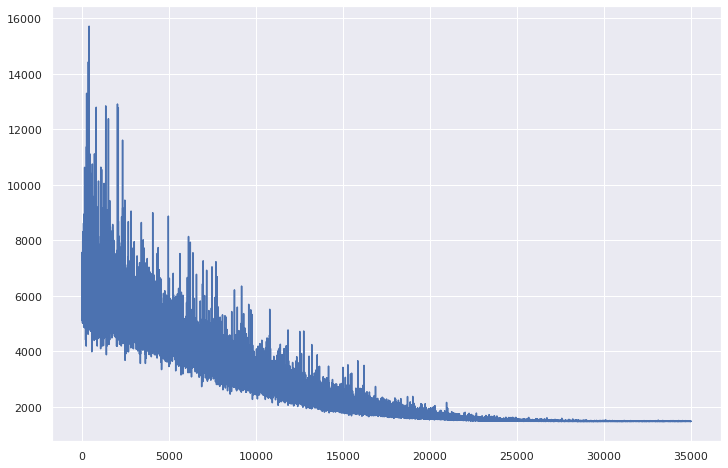

In [37]:
#number of iterations of the algorithms
iter = 35000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [38]:
# samples from the posterior
posterior = approximation.sample(5000)

In [39]:
len(y_test)

476

In [40]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  173381.24785732152
MAPE =  0.2810990498137445


## Clustering

#### Optimal Cluster Components

In [41]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


In [42]:
rel_features

['longitude',
 'latitude',
 'surface',
 'ber_classification',
 'bathrooms',
 'beds',
 'semi-detached',
 'parking',
 'terraced',
 'gas_fired_central_heating',
 'postcode_north_south',
 'wired_for_cable_television',
 'apartment',
 'detached',
 'alarm']

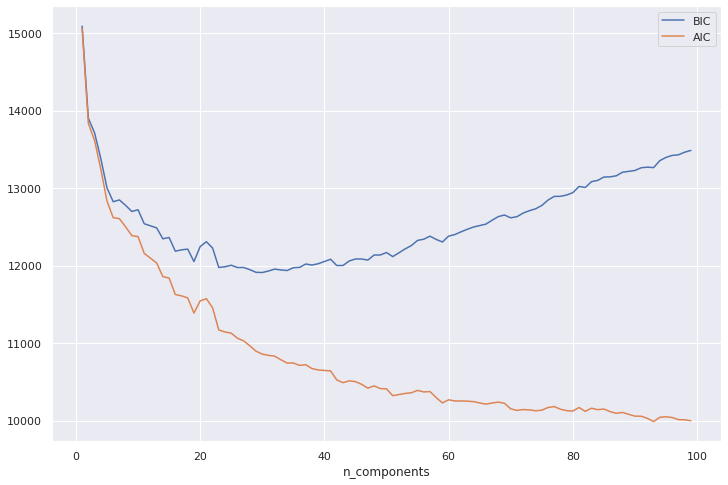

In [43]:
from sklearn.mixture import GaussianMixture

# We will use Akaike information criterion (AIC) 
# or the Bayesian information criterion (BIC) to choose the best number of components when
# clustering.

# Using https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html as inspiration.

# Using Long/Lat for the Gaussian Clustering
ind=[0, 1]

n_components = np.arange(1, 100)
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_ind)
          for n in n_components]

plt.plot(n_components, [m.bic(X_ind) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_ind) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');


Above I use AIC and BIC methods for getting the optimial number of clusters.  
This was taken from VanderPlas (2015).  
However running the examples with >20 is unfeasible, and returns a high value for the MAE.  
Therefore I am disregarding above and using 4 clusters.

In [44]:
# Number of components
component = 4

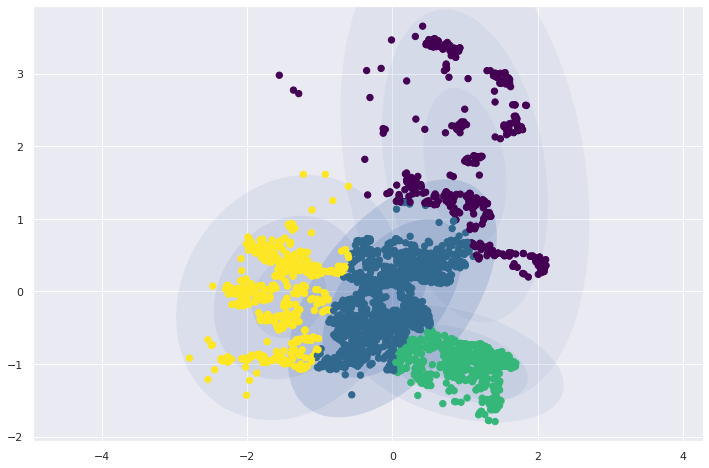

In [45]:
# Plot 2d GaussianMixture density distributions

gmm = GaussianMixture(n_components=component, covariance_type='full', random_state=42)
plot_gmm(gmm, X_ind)

#### Apply Cluster Components

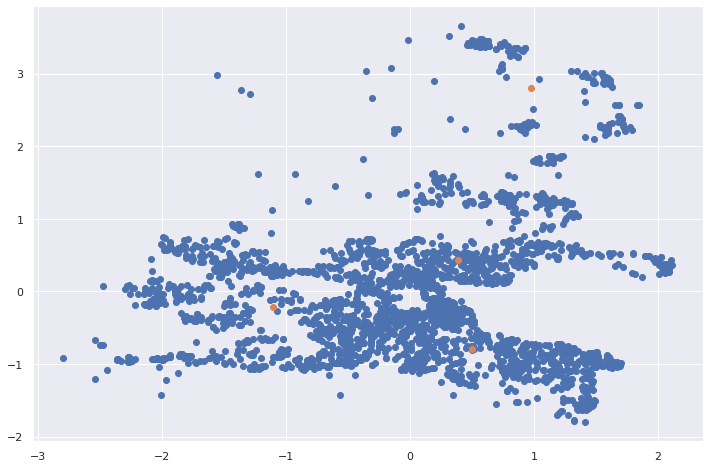

In [46]:
# training gaussian mixture model 

gmm = GaussianMixture(n_components=component)
# clustering by features 1, 2
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [47]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 632, 1: 703, 2: 717, 3: 126}

In [48]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 119, 1: 147, 2: 168, 3: 42}

## Piecewise Model

In [49]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred


In [50]:
# Create a dictiornary to store cluster components
# This will allow the code to run more dynamically, and I could add extra clusters trivially

# Cluster Data
cd = {}


Cluster 0 has size of 632 rows.


Finished [100%]: Average Loss = 495.06


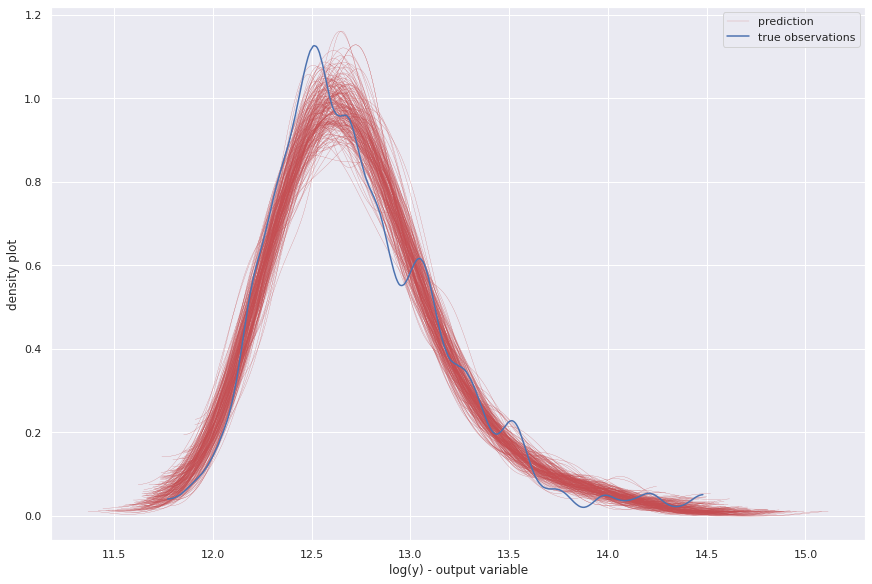

Cluster 1 has size of 703 rows.


Finished [100%]: Average Loss = 598.12


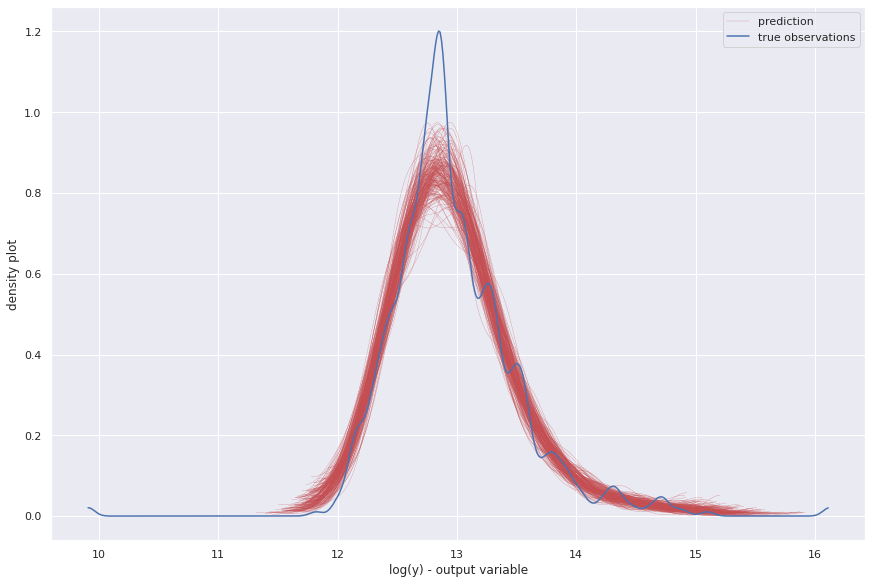

Cluster 2 has size of 717 rows.


Finished [100%]: Average Loss = 396


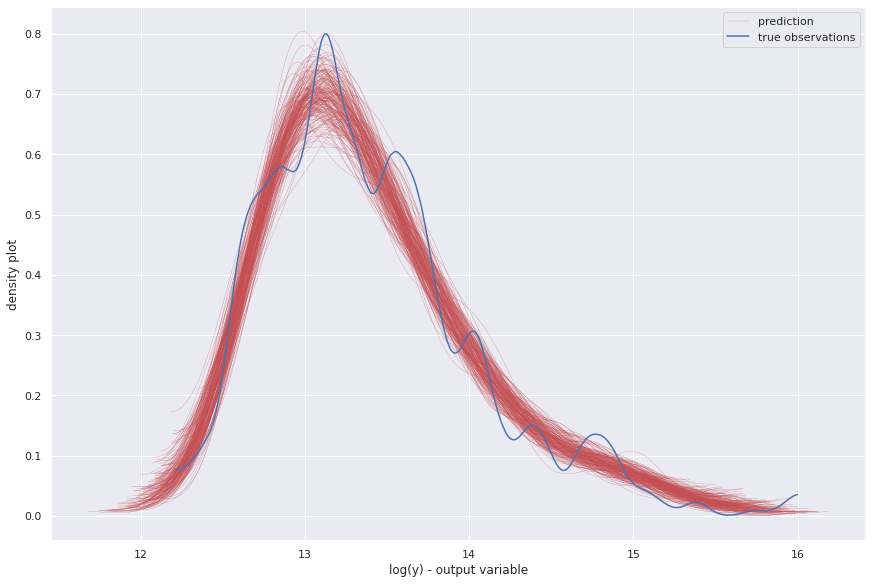

Cluster 3 has size of 126 rows.


Finished [100%]: Average Loss = 189.7


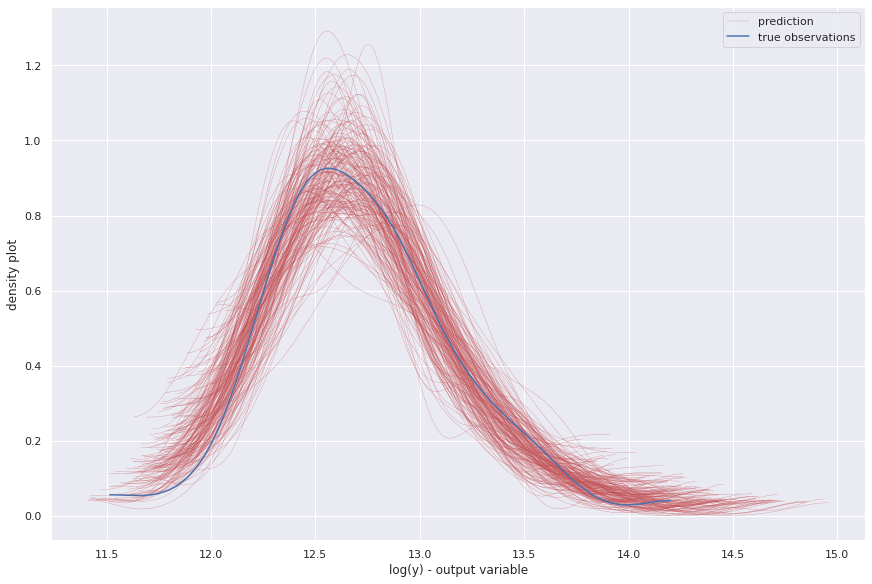

In [51]:
for j in range(component):
    cd_temp = {}
    cd_temp["Xn"] = Xn_train[clusters_train==j,:]
    cd_temp["Xtestn"] = Xn_test[clusters_test==j,:]

    cd_temp["ylog"] = np.log(ys_train.astype('float')[clusters_train==j,:])
    cd_temp["yscaler"] = StandardScaler().fit(cd_temp["ylog"])
    cd_temp["yn"] = cd_temp["yscaler"].transform(cd_temp["ylog"])
    print(f"Cluster {j} has size of {len(cd_temp['Xn'])} rows.")

    with pm.Model() as model_:
        # prior over the parameters of linear regression
        alpha = pm.Normal('alpha', mu=0, sigma=30)
        # we have a beta for each column of Xn0
        beta = pm.Normal('beta', mu=0, sigma=30, shape=cd_temp["Xn"].shape[1])
        # prior over the variance of the noise
        sigma = pm.HalfCauchy('sigma_n', 5)
        # linear regression relationship
        #linear regression model in matrix form
        mu = alpha + pm.math.dot(beta, cd_temp["Xn"].T)
        # likelihood, be sure that observed is a 1d vector
        like = pm.Normal('like', mu=mu, sigma=sigma, observed=cd_temp["yn"][:,0])

    with model_:
        # iterations of the algorithm
        approximation = pm.fit(40000,method='advi')

    # samples from the posterior   
    cd_temp["posterior"] = approximation.sample(5000)

    #Simulation
    Ypred = cd_temp["yscaler"].inverse_transform(ppc(
        cd_temp["posterior"]['alpha'],
        cd_temp["posterior"] ['beta'],
        cd_temp["posterior"] ['sigma_n'],cd_temp["Xn"],  nsamples=200))

    for i in range(Ypred.shape[0]):
        az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
    az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
    #plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
    #plt.xlim([0,10e7])
    az.plot_dist(cd_temp["ylog"],label='true observations');
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot");
    plt.show()

    cd[j] = cd_temp


## Overall

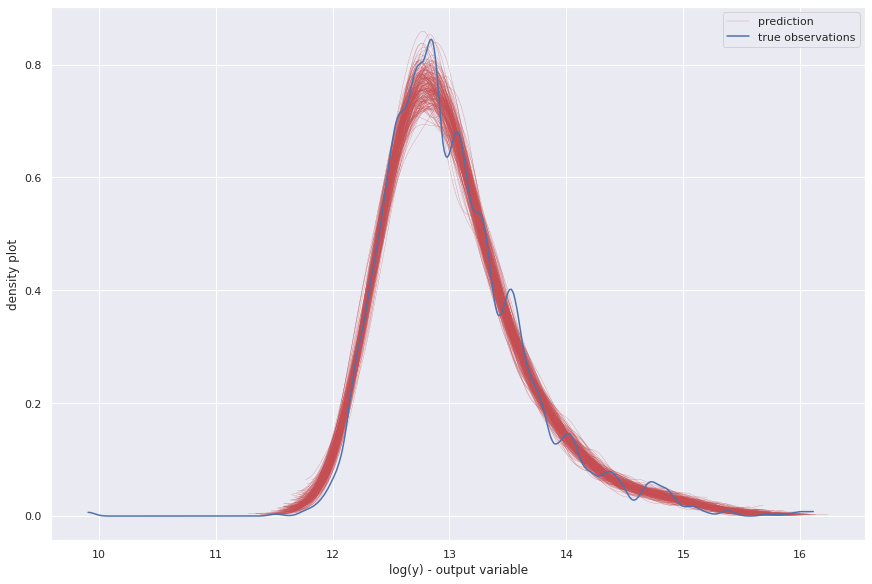

In [52]:
# posteriors
YPred_ = [cd[j]["yscaler"].inverse_transform(
    ppc(
        cd[j]["posterior"]['alpha'],
        cd[j]["posterior"]['beta'],
        cd[j]["posterior"]['sigma_n'],
        cd[j]["Xn"],
        nsamples=200)) for j in range(component)]

# simulation
Ypred = np.hstack(YPred_)

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([cd[j]["ylog"] for j in range(component)])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [53]:
for j in range(component):
    y_pred_BLR = np.exp(cd[j]["yscaler"].inverse_transform(np.mean(cd[j]["posterior"]['alpha']) 
                  + np.dot(np.mean(cd[j]["posterior"]['beta'],axis=0), cd[j]["Xtestn"].T)))
    
    print(f"Size Cluster{j}", np.sum(clusters_test==j), f", MAE Cluster{j}=",
          (np.mean(abs(y_pred_BLR - y_test[clusters_test==j]))))
    
    cd[j]["y_pred_BLR"] = y_pred_BLR

abs_ = [
    abs(cd[j]["y_pred_BLR"] - y_test[clusters_test==j])
    for j in range(component)]

# joint
joint=np.hstack(abs_)

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 119 , MAE Cluster0= 95294.41590212003
Size Cluster1 147 , MAE Cluster1= 116411.82767466392
Size Cluster2 168 , MAE Cluster2= 228430.72376256072
Size Cluster3 42 , MAE Cluster3= 147151.11596427872
MAE= 153380.84584692813


### PPC on the Test set



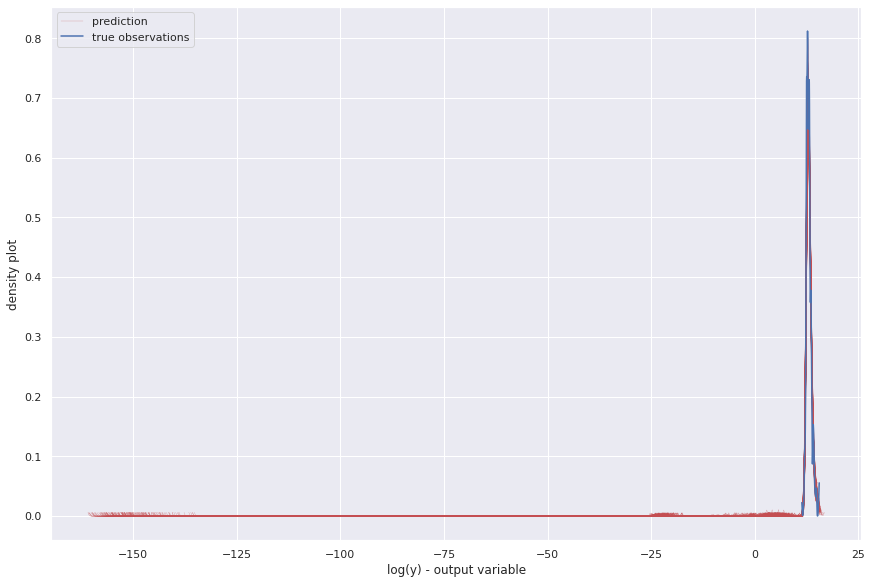

In [54]:
## Posterior predictive checks (PPCs)

# posteriors
YPred_ = [cd[j]["yscaler"].inverse_transform(
    ppc(
        cd[j]["posterior"]['alpha'],
        cd[j]["posterior"]['beta'],
        cd[j]["posterior"]['sigma_n'],
        cd[j]["Xtestn"],
        nsamples=200)) for j in range(component)]

# simulation
Ypred = np.hstack(YPred_)
# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY

In summery, we can see that the peicewise model works better than a non-peicewise regular regression model.  
This is to be expected as the peicewise model can be fit on segments of the data that are broadly linear, while the entirety may not have that form of relationship.  

I have improved the code by saving the cluster information into a dictionary.  
This has teh advantage of beinging able to more easily customise the number of clusters.

Regular Linear Regression returned a Mean Absolute Error (MAE) of 173381.24785732152.  
Piecewise Linear Regression returned a Mean Absolute Error (MAE) of 153380.84584692813.  

###### Notes:
I struggled to select the correct number of features.  
I parsed out the features, and the publin postcodes.  
However when using XGBoost (inspiration from Olga Minnuett), the best features were:
* latitude
* longitude
* surface
* ber_classification
* bathrooms
* beds  
* semi-detached
* parking
* terraced
* gas_fired_central_heating
* postcode_north_south
* wired_for_cable_television
* apartment
* detached
* alarm

I had some assumptions on the property_type, and postcode, however when implementing them into the model the MAE increased substantially.  
I found the optimal XGBoost F score threshold by manually checking all the thresholds.  


Another struggle I had was to pick the correct features to apply Guassian Mixtures on to segment the data on.  
I used Longatude and Latitude, however I am not sure this is the best features.  
However it is the best form of continious feature, better for clustering, and viewing the scatterplot og long/lat the corresponded to Dublin areas.
These are:
* North County Dublin
* Western Dublin
* Dun Laoghaire- Rathdown
* Dublin City

Adding more clusters did not increase the accuracy substantially.  
I had hoped that using the Akaike information criterion (AIC) and Bayesian information criterion (BIC) would have helped to choose the optimal number of clusters, however I found in practice that this did not help, when manually running peicewise with different clusters.  

I found that peicewise has many advantages, we need to be careful on the number of clusters.  
In this case, when I used more than 15 clusters, the results quickly deteriated as each regression model has very sparse data in teh training process, and the lack of data per model decreases its accuracy.

Initial Results:
* MAE =  173381.24785732152
* MAPE =  0.2810990498137445

Piecewise Results:
* Size Cluster0 119 , MAE Cluster0= 95294.41590212003
* Size Cluster1 147 , MAE Cluster1= 116411.82767466392
* Size Cluster2 168 , MAE Cluster2= 228430.72376256072
* Size Cluster3 42 , MAE Cluster3= 147151.11596427872
* MAE= 153380.84584692813


# References

Gadekar, A., 2021. Feature Importance In Machine Learning using XG Boost | Python. [online] CodeSpeedy. Available at: https://www.codespeedy.com/feature-importance-in-machine-learning-using-xg-boost/ [Accessed 02 October 2021].

VanderPlas, J., 2016, Python Data Science Handbook.  O'Reilly Media, Inc. Available at: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html [Accessed 02 October 2021].